# Decision Tree Evaluation

The purpose of this project is to apply a decision tree model to predict occurance of a wildfire, based on NASA satellite measurement data. In this notebook, I build a decision tree model, tune the relevant hyper parameters, and then identify feature importance in the tree's decision making.

In [1]:
# Standard library imports
import os

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.model_selection import train_test_split

# Configuration
DATA_PATH = "../data/final_combined_dataset.csv"
RANDOM_STATE = 1234
TEST_SIZE = 0.2
VAL_SIZE = 0.2

# Load dataset
data = pd.read_csv(DATA_PATH)

# Prepare features and target
X = data.drop(["FIRE", "Date"], axis=1)
y = data['FIRE']

# Split data: train_all -> (train + val) and test
X_train_all, X_test, y_train_all, y_test, data_train_all, data_test = train_test_split(
    X, y, data, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Create validation set from training data
X_train, X_val, y_train, y_val, data_train, data_val = train_test_split(
    X_train_all, y_train_all, data_train_all, test_size=VAL_SIZE, random_state=RANDOM_STATE
)

# Display dataset shapes
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)
print("Test labels shape:", y_test.shape)

/home/paul/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Training set shape: (19168, 12)
Validation set shape: (4792, 12)
Test set shape: (5990, 12)
Training labels shape: (19168,)
Validation labels shape: (4792,)
Test labels shape: (5990,)


Create necessary methods

,name,Training Accuracy,Eval Accuracy,Training Recall,Eval Recall,Training Precision,Eval Precision,Training F1,Eval F1
0,Decision Tree,1.0,0.958681,1.0,0.960593,1.0,0.955734,1.0,0.958157



Training Decision Tree...


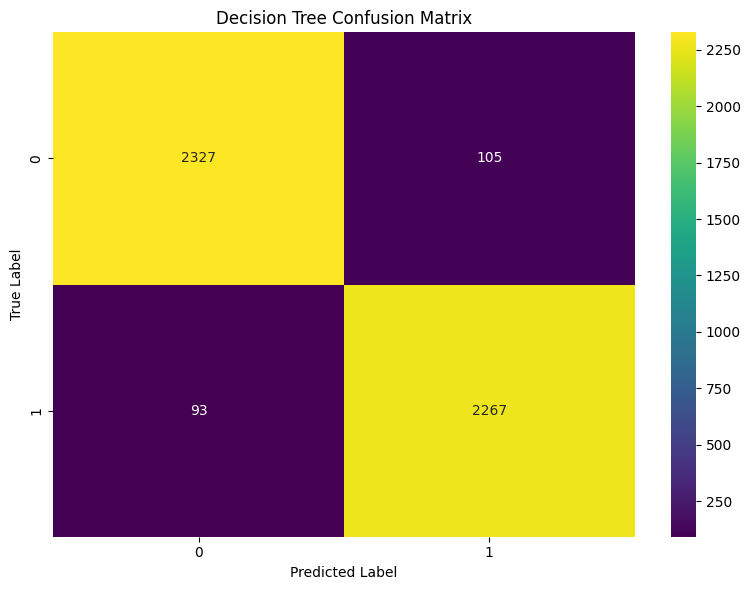

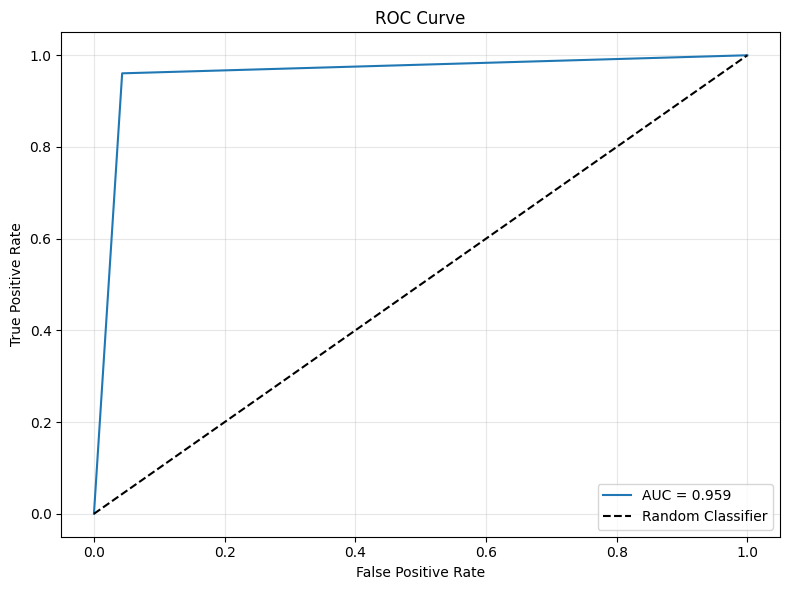

Tree depth: 29


In [2]:
# Scikit-learn imports
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)


def evaluate_pipelines(pipelines, X_train, y_train, X_evaluate, y_evaluate):

    rows = []
    for name, pipeline in pipelines:
        pipeline.fit(X_train, y_train)
        
        train_preds = pipeline.predict(X_train)
        eval_preds = pipeline.predict(X_evaluate)
        
        rows.append({
            'name': name,
            'Training Accuracy': accuracy_score(y_train, train_preds),
            'Eval Accuracy': accuracy_score(y_evaluate, eval_preds),
            'Training Recall': recall_score(y_train, train_preds),
            'Eval Recall': recall_score(y_evaluate, eval_preds),
            'Training Precision': precision_score(y_train, train_preds),
            'Eval Precision': precision_score(y_evaluate, eval_preds),
            'Training F1': f1_score(y_train, train_preds),
            'Eval F1': f1_score(y_evaluate, eval_preds)
        })
    
    return pd.DataFrame(rows)


def plot_confusion_matrix(y_true, y_pred, clf_name):

    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='viridis')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{clf_name} Confusion Matrix')
    plt.tight_layout()
    plt.show()


def plot_roc_curve(y_true, y_probs):

    auc = roc_auc_score(y_true, y_probs)
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# Initialize baseline decision tree
decision_tree = make_pipeline(
    DecisionTreeClassifier(random_state=RANDOM_STATE)
)

# Evaluate baseline model
pipelines = [('Decision Tree', decision_tree)]
results_df = evaluate_pipelines(pipelines, X_train, y_train, X_val, y_val)
display(results_df)

# Generate visualizations
for name, clf in pipelines:
    print(f"\nTraining {name}...")
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_val)
    y_probs = clf.predict_proba(X_val)[:, 1]
    
    plot_confusion_matrix(y_val, y_pred, name)
    plot_roc_curve(y_val, y_probs)
    
    # Display tree depth
    tree = clf.named_steps['decisiontreeclassifier']
    depth = tree.get_depth()
    print(f"Tree depth: {depth}")

## Tuning Hyperparameters
- We've established a high baseline accuracy for decision trees here, with train and validation set only.
- Tune HPs to increase AUC score

Performing grid search...


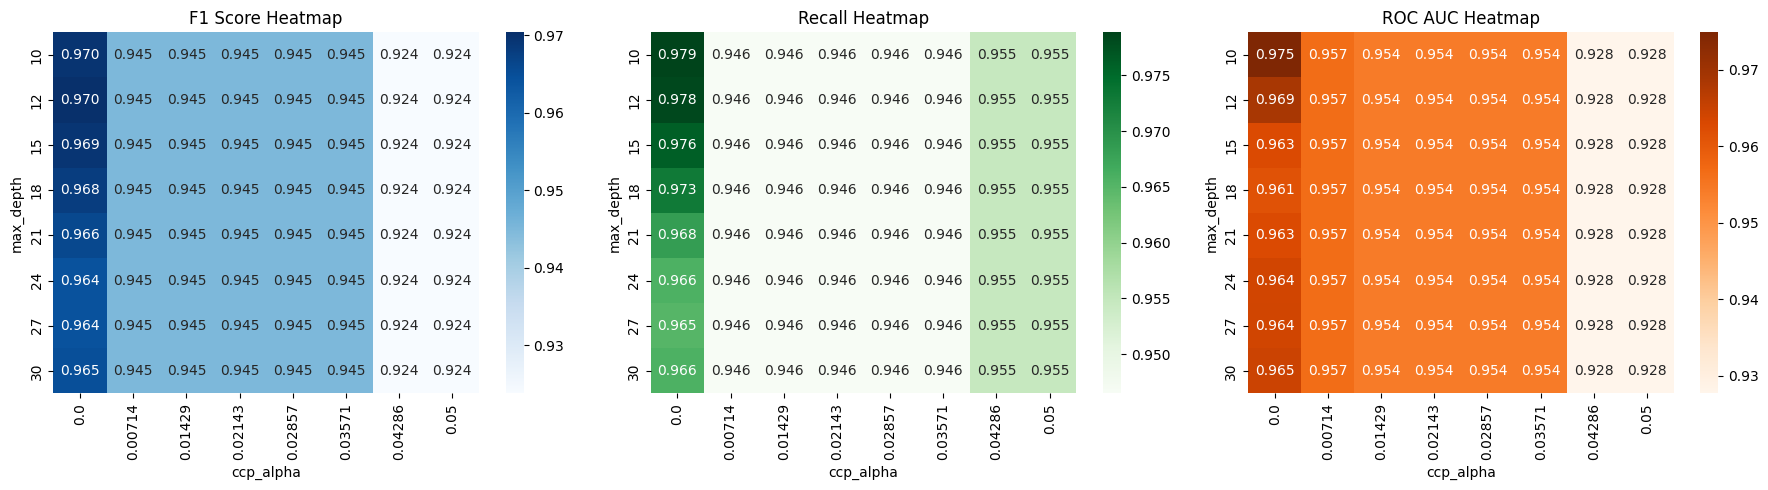

In [3]:
# Hyperparameter Tuning: Initial Grid Search
# Using 5-fold cross-validation to tune max_depth and ccp_alpha

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score, recall_score

# Define hyperparameter search space
alphas = np.linspace(0, 0.05, 8)
max_depths = np.linspace(10, 30, num=8, dtype=int)

# Initialize result dataframes
f1_results = pd.DataFrame(index=max_depths, columns=np.round(alphas, 5))
recall_results = pd.DataFrame(index=max_depths, columns=np.round(alphas, 5))
roc_results = pd.DataFrame(index=max_depths, columns=np.round(alphas, 5))

# Perform grid search with 5-fold cross-validation
print("Performing grid search...")
for depth in max_depths:
    for alpha in alphas:
        clf = DecisionTreeClassifier(
            max_depth=depth,
            ccp_alpha=alpha,
            random_state=RANDOM_STATE
        )
        
        f1 = cross_val_score(
            clf, X_train_all, y_train_all,
            cv=5, scoring=make_scorer(f1_score)
        ).mean()
        
        recall = cross_val_score(
            clf, X_train_all, y_train_all,
            cv=5, scoring=make_scorer(recall_score)
        ).mean()
        
        roc = cross_val_score(
            clf, X_train_all, y_train_all,
            cv=5, scoring='roc_auc'
        ).mean()
        
        col_key = round(alpha, 5)
        f1_results.loc[depth, col_key] = f1
        recall_results.loc[depth, col_key] = recall
        roc_results.loc[depth, col_key] = roc

# Convert to float for plotting
f1_results = f1_results.astype(float)
recall_results = recall_results.astype(float)
roc_results = roc_results.astype(float)

# Plot heatmaps
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.heatmap(f1_results, annot=True, fmt=".3f", cmap="Blues")
plt.title("F1 Score Heatmap")
plt.xlabel("ccp_alpha")
plt.ylabel("max_depth")

plt.subplot(1, 3, 2)
sns.heatmap(recall_results, annot=True, fmt=".3f", cmap="Greens")
plt.title("Recall Heatmap")
plt.xlabel("ccp_alpha")
plt.ylabel("max_depth")

plt.subplot(1, 3, 3)
sns.heatmap(roc_results, annot=True, fmt=".3f", cmap="Oranges")
plt.title("ROC AUC Heatmap")
plt.xlabel("ccp_alpha")
plt.ylabel("max_depth")

plt.tight_layout()
plt.show()


## More Hyperparameter Tuning
- Based on the previous heatmaps, seems like a very small alpha is best
- I'm going to narrow in the upper left corners of the heatmaps
- Note that I'm thinking about how to maximizing ROC AUC, because I believe this is the most important metric in the context of fire detection

Performing refined grid search...


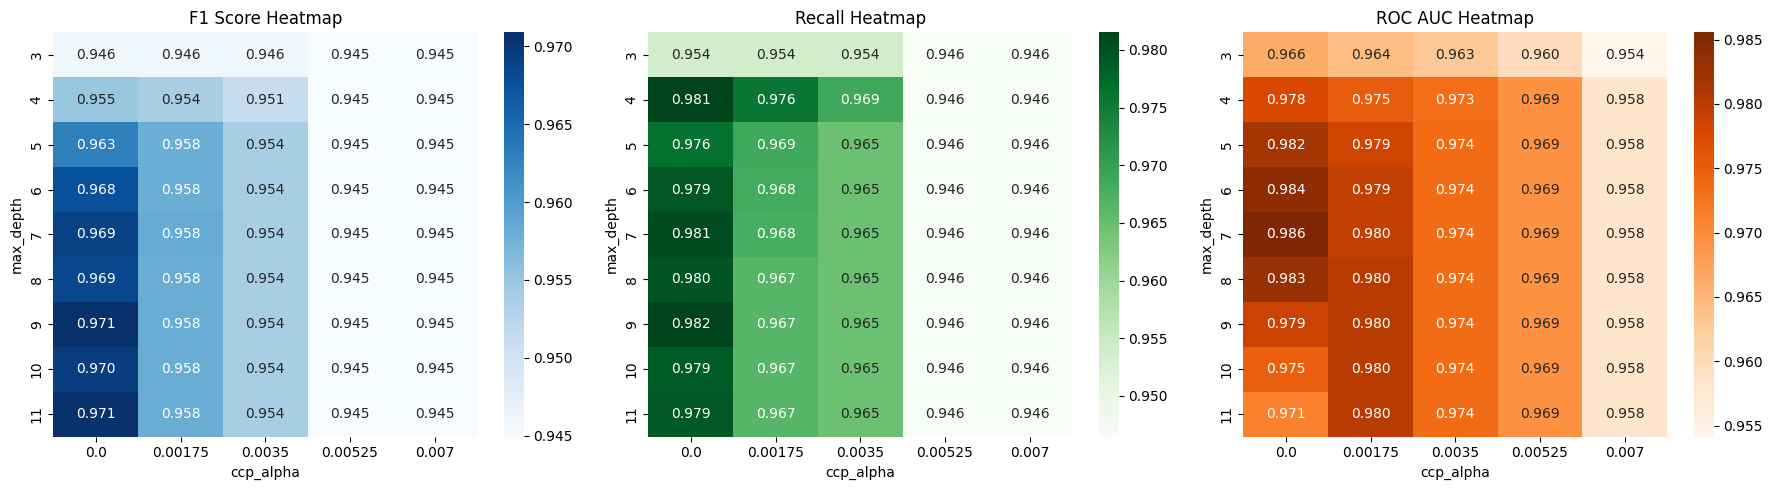

In [4]:
# Refined Hyperparameter Tuning
# Narrowing search space based on initial results

alphas = np.linspace(0, 0.007, 5)
max_depths = np.linspace(3, 11, num=9, dtype=int)

# Initialize result dataframes
f1_results = pd.DataFrame(index=max_depths, columns=np.round(alphas, 5))
recall_results = pd.DataFrame(index=max_depths, columns=np.round(alphas, 5))
roc_results = pd.DataFrame(index=max_depths, columns=np.round(alphas, 5))

# Perform grid search
print("Performing refined grid search...")
for depth in max_depths:
    for alpha in alphas:
        clf = DecisionTreeClassifier(
            max_depth=depth,
            ccp_alpha=alpha,
            random_state=RANDOM_STATE
        )
        
        f1 = cross_val_score(
            clf, X_train_all, y_train_all,
            cv=5, scoring=make_scorer(f1_score)
        ).mean()
        
        recall = cross_val_score(
            clf, X_train_all, y_train_all,
            cv=5, scoring=make_scorer(recall_score)
        ).mean()
        
        roc = cross_val_score(
            clf, X_train_all, y_train_all,
            cv=5, scoring='roc_auc'
        ).mean()
        
        col_key = round(alpha, 5)
        f1_results.loc[depth, col_key] = f1
        recall_results.loc[depth, col_key] = recall
        roc_results.loc[depth, col_key] = roc

# Convert to float for plotting
f1_results = f1_results.astype(float)
recall_results = recall_results.astype(float)
roc_results = roc_results.astype(float)

# Plot heatmaps
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.heatmap(f1_results, annot=True, fmt=".3f", cmap="Blues")
plt.title("F1 Score Heatmap")
plt.xlabel("ccp_alpha")
plt.ylabel("max_depth")

plt.subplot(1, 3, 2)
sns.heatmap(recall_results, annot=True, fmt=".3f", cmap="Greens")
plt.title("Recall Heatmap")
plt.xlabel("ccp_alpha")
plt.ylabel("max_depth")

plt.subplot(1, 3, 3)
sns.heatmap(roc_results, annot=True, fmt=".3f", cmap="Oranges")
plt.title("ROC AUC Heatmap")
plt.xlabel("ccp_alpha")
plt.ylabel("max_depth")

plt.tight_layout()
plt.show()

## One more round of HP tuning to zero in on optimal range of CCCP alpha

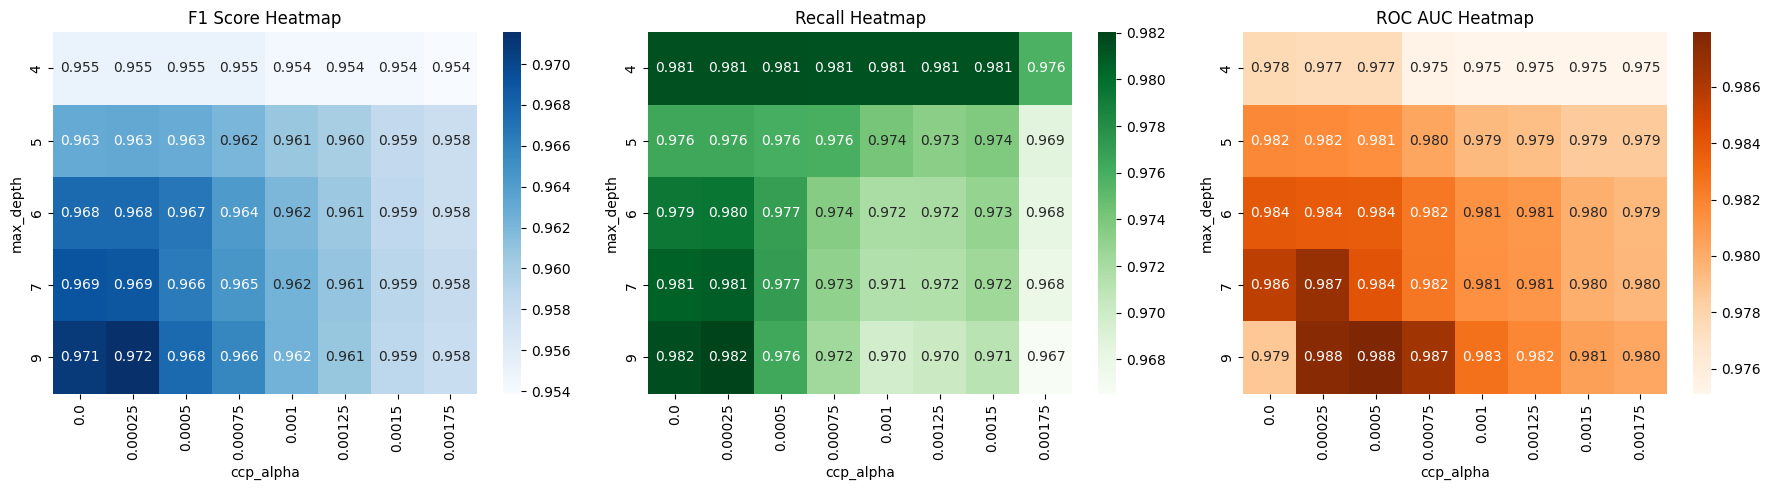

In [5]:
# Generate a reasonable range for alpha tuning
alphas = np.linspace(0, 0.00175, 8)

# Generate a reasonable range for max depth tuning
max_depths = np.linspace(4, 9, num=5, dtype=int)

# Initialize result dataframes
f1_results = pd.DataFrame(index=max_depths, columns=np.round(alphas, 5))
recall_results = pd.DataFrame(index=max_depths, columns=np.round(alphas, 5))
roc_results = pd.DataFrame(index=max_depths, columns=np.round(alphas, 5))

# Perform grid search manually with 5-fold cross-validation
for depth in max_depths:
    for alpha in alphas:
        clf = DecisionTreeClassifier(max_depth=depth, ccp_alpha=alpha, random_state=1234)

        f1 = cross_val_score(clf, X_train_all, y_train_all, cv=5, scoring=make_scorer(f1_score)).mean()
        recall = cross_val_score(clf, X_train_all, y_train_all, cv=5, scoring=make_scorer(recall_score)).mean()
        roc = cross_val_score(clf, X_train_all, y_train_all, cv=5, scoring='roc_auc').mean()

        col_key = round(alpha, 5)
        f1_results.loc[depth, col_key] = f1
        recall_results.loc[depth, col_key] = recall
        roc_results.loc[depth, col_key] = roc

# Convert to float for correct plotting
f1_results = f1_results.astype(float)
recall_results = recall_results.astype(float)
roc_results = roc_results.astype(float)

# Plot heatmaps
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.heatmap(f1_results, annot=True, fmt=".3f", cmap="Blues")
plt.title("F1 Score Heatmap")
plt.xlabel("ccp_alpha")
plt.ylabel("max_depth")

plt.subplot(1, 3, 2)
sns.heatmap(recall_results, annot=True, fmt=".3f", cmap="Greens")
plt.title("Recall Heatmap")
plt.xlabel("ccp_alpha")
plt.ylabel("max_depth")

plt.subplot(1, 3, 3)
sns.heatmap(roc_results, annot=True, fmt=".3f", cmap="Oranges")
plt.title("ROC AUC Heatmap")
plt.xlabel("ccp_alpha")
plt.ylabel("max_depth")

plt.tight_layout()
plt.show()



## One more round


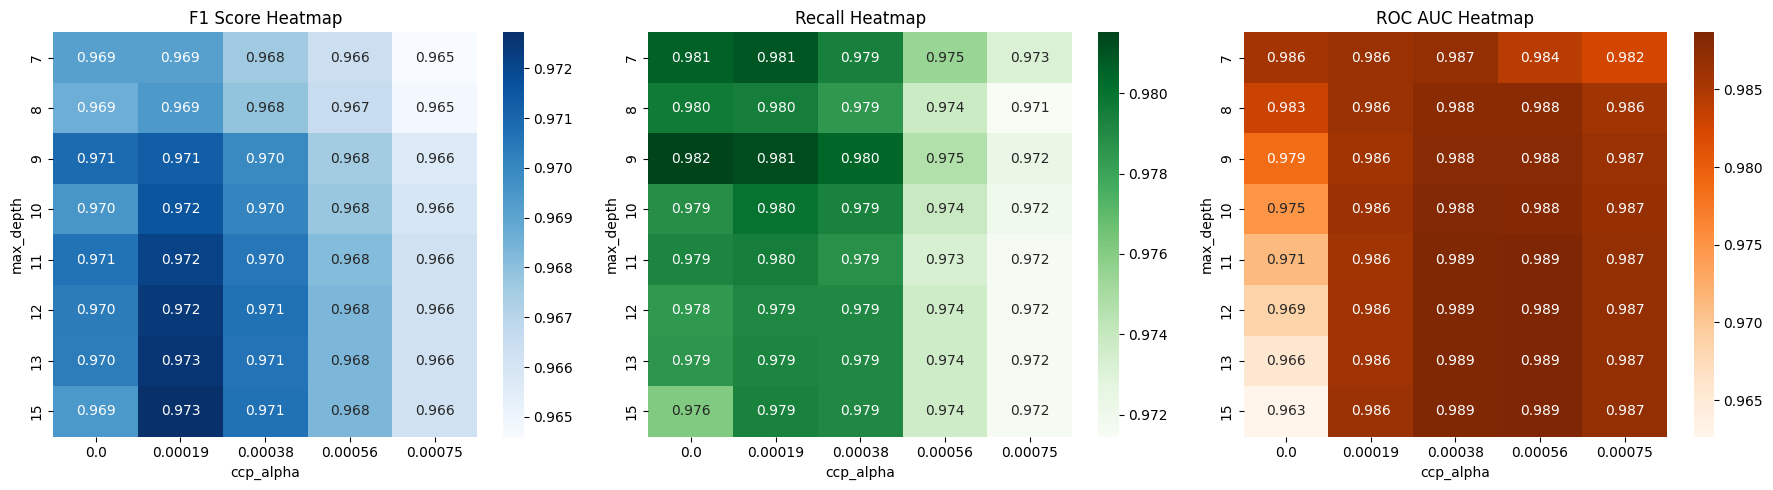

In [6]:
## Final Round
# Generate a reasonable range for alpha tuning
alphas = np.linspace(0, 0.00075, 5)

# Generate a reasonable range for max depth tuning
max_depths = np.linspace(7, 15, num=8, dtype=int)

# Initialize result dataframes
f1_results = pd.DataFrame(index=max_depths, columns=np.round(alphas, 5))
recall_results = pd.DataFrame(index=max_depths, columns=np.round(alphas, 5))
roc_results = pd.DataFrame(index=max_depths, columns=np.round(alphas, 5))

# Perform grid search manually with 5-fold cross-validation
for depth in max_depths:
    for alpha in alphas:
        clf = DecisionTreeClassifier(max_depth=depth, ccp_alpha=alpha, random_state=1234)

        f1 = cross_val_score(clf, X_train_all, y_train_all, cv=5, scoring=make_scorer(f1_score)).mean()
        recall = cross_val_score(clf, X_train_all, y_train_all, cv=5, scoring=make_scorer(recall_score)).mean()
        roc = cross_val_score(clf, X_train_all, y_train_all, cv=5, scoring='roc_auc').mean()

        col_key = round(alpha, 5)
        f1_results.loc[depth, col_key] = f1
        recall_results.loc[depth, col_key] = recall
        roc_results.loc[depth, col_key] = roc

# Convert to float for correct plotting
f1_results = f1_results.astype(float)
recall_results = recall_results.astype(float)
roc_results = roc_results.astype(float)

# Plot heatmaps
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.heatmap(f1_results, annot=True, fmt=".3f", cmap="Blues")
plt.title("F1 Score Heatmap")
plt.xlabel("ccp_alpha")
plt.ylabel("max_depth")

plt.subplot(1, 3, 2)
sns.heatmap(recall_results, annot=True, fmt=".3f", cmap="Greens")
plt.title("Recall Heatmap")
plt.xlabel("ccp_alpha")
plt.ylabel("max_depth")

plt.subplot(1, 3, 3)
sns.heatmap(roc_results, annot=True, fmt=".3f", cmap="Oranges")
plt.title("ROC AUC Heatmap")
plt.xlabel("ccp_alpha")
plt.ylabel("max_depth")

plt.tight_layout()
plt.show()

I will opt for max_depth of 11, ccp_alpha of .00038. These maximize ROC AUC, but also have high values for f1 and Recall, while balancing a tree size that isn't too large.

## Creating Final Decision Tree
- Choosing hyperaparameter values seem to be max_depth of 8, and  ccp_alpha value of .00044. This is the simplest possible tree with the highest ROC.
- First I will get the stats for this on the test data set, then I will extract feature importance.


In [7]:
print(data_test.head())

           Date  Latitude   Longitude  WS2M    T2M  T2M_MAX  T2M_MIN  T2MDEW  \
22895  20200805  39.89363 -105.504510  1.00  18.50    27.81    10.76    3.56   
24145  20000718  37.29306 -107.221670  0.51  16.52    26.04     8.91   -0.95   
24195  19900704  37.67361 -108.456940  0.75  23.35    31.28    14.67    4.68   
14286  20101008  36.96136  -99.565627  3.50  22.43    31.62    14.73    7.08   
28496  20190913  44.53806 -104.429440  1.91  15.07    23.65     6.26    5.58   

        RH2M     PS  ALLSKY_SFC_LW_DWN  ALLSKY_SFC_SW_DWN  ALLSKY_SFC_SW_DIFF  \
22895  43.92  73.90              28.44              22.19                9.71   
24145  37.14  71.94              25.44              28.65                8.93   
24195  34.00  79.80              29.60              27.15               12.10   
14286  41.59  94.93              28.22              19.39                2.35   
28496  58.56  86.76              25.57              21.56                3.19   

       FIRE  
22895     1  
2414

,name,Training Accuracy,Eval Accuracy,Training Recall,Eval Recall,Training Precision,Eval Precision,Training F1,Eval F1
0,Decision Tree (Tuned),0.972579,0.966611,0.979774,0.970027,0.966024,0.962162,0.97285,0.966079



Training Decision Tree (Tuned)...


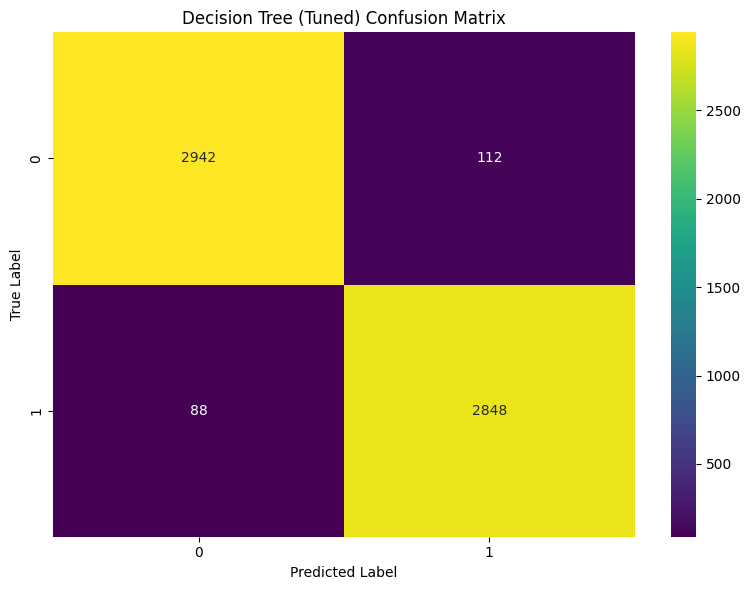

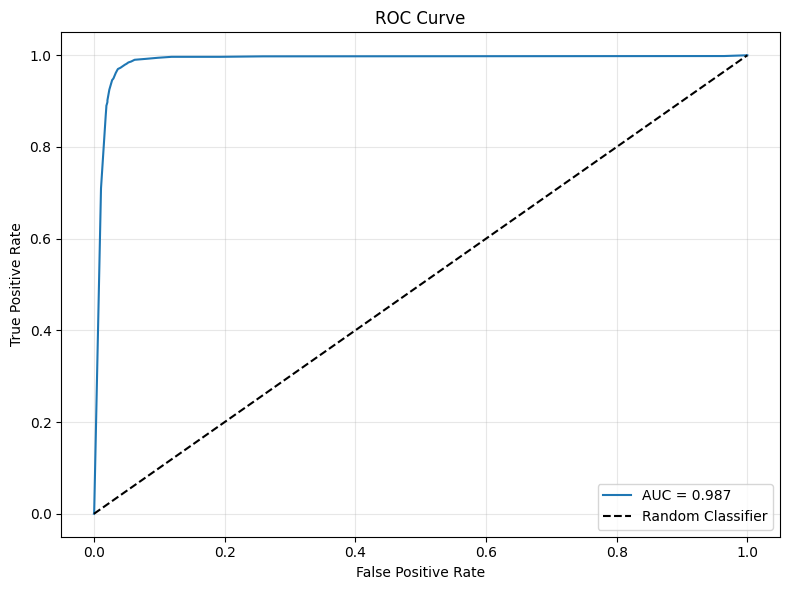

Tree depth: 10


In [8]:
# Final Model Evaluation
# Using optimal hyperparameters: max_depth=11, ccp_alpha=0.00038

final_decision_tree = make_pipeline(
    DecisionTreeClassifier(
        max_depth=11,
        ccp_alpha=0.00038,
        random_state=RANDOM_STATE
    )
)

# Evaluate on test set
pipelines = [('Decision Tree (Tuned)', final_decision_tree)]
results_df = evaluate_pipelines(
    pipelines, X_train_all, y_train_all, X_test, y_test
)
display(results_df)

# Generate visualizations
for name, clf in pipelines:
    print(f"\nTraining {name}...")
    clf.fit(X_train_all, y_train_all)
    
    y_pred = clf.predict(X_test)
    y_probs = clf.predict_proba(X_test)[:, 1]
    
    plot_confusion_matrix(y_test, y_pred, name)
    plot_roc_curve(y_test, y_probs)
    
    # Display tree depth
    final_tree = clf.named_steps['decisiontreeclassifier']
    depth = final_tree.get_depth()
    print(f"Tree depth: {depth}")

- The above tree has a very high AUC, and a very small recall.
- This is great!

## Now lets get an idea of feature importance.

Feature Importances:
               Feature  Importance
8                   PS    0.685738
1            Longitude    0.149774
0             Latitude    0.128444
4              T2M_MAX    0.017226
6               T2MDEW    0.008749
5              T2M_MIN    0.004762
7                 RH2M    0.001854
2                 WS2M    0.001829
3                  T2M    0.001625
9    ALLSKY_SFC_LW_DWN    0.000000
10   ALLSKY_SFC_SW_DWN    0.000000
11  ALLSKY_SFC_SW_DIFF    0.000000


/tmp/ipykernel_24670/4049495237.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


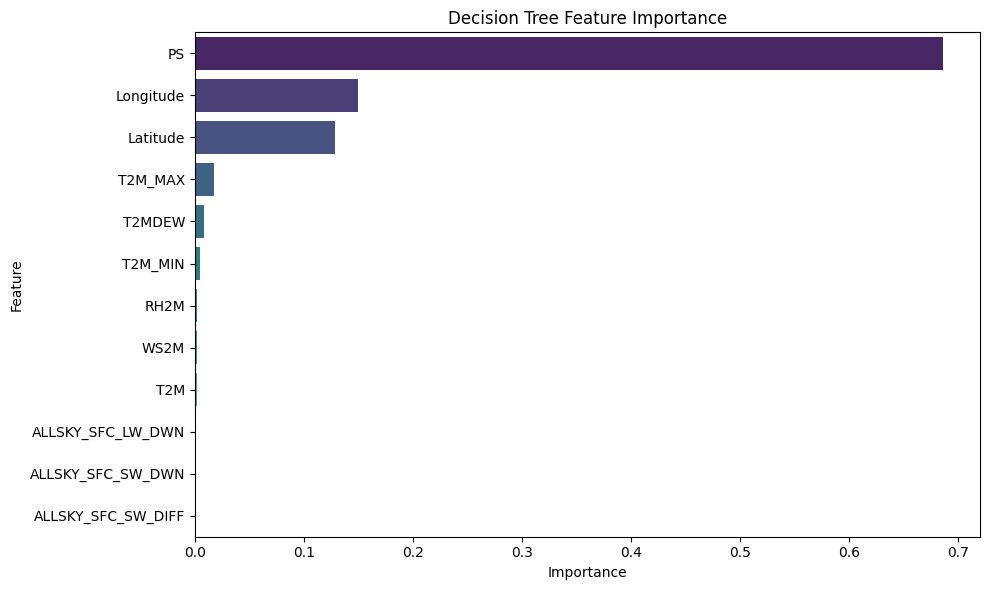

In [9]:
# Feature Importance Analysis
# Extract feature importances from the trained decision tree

importances = final_tree.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train_all.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importance_df)

# Visualize feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title("Decision Tree Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

Permutation Feature Importance:
               Feature  Importance
8                   PS    0.330055
1            Longitude    0.065328
0             Latitude    0.058081
4              T2M_MAX    0.006793
2                 WS2M    0.004528
5              T2M_MIN    0.001054
7                 RH2M    0.000151
6               T2MDEW    0.000098
3                  T2M    0.000026
9    ALLSKY_SFC_LW_DWN    0.000000
10   ALLSKY_SFC_SW_DWN    0.000000
11  ALLSKY_SFC_SW_DIFF    0.000000


/tmp/ipykernel_24670/1022987100.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Feature', x='Importance', data=perm_df, palette='viridis')


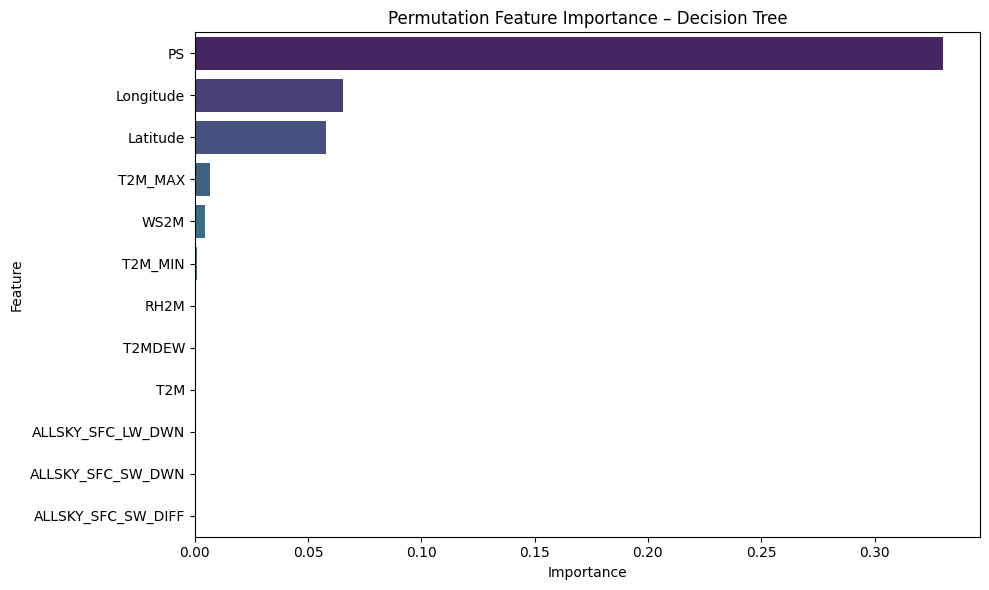

In [10]:
# Permutation Feature Importance
# More robust measure of feature importance using permutation

from sklearn.inspection import permutation_importance

perm = permutation_importance(
    estimator=final_tree,
    X=X_test,
    y=y_test,
    n_repeats=15,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

# Create DataFrame with results
perm_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm.importances_mean
}).sort_values('Importance', ascending=False)

print("Permutation Feature Importance:")
print(perm_df)

# Visualize permutation importance
plt.figure(figsize=(10, 6))
sns.barplot(y='Feature', x='Importance', data=perm_df, palette='viridis')
plt.title("Permutation Feature Importance – Decision Tree")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## Looking at misclassifications
- Look at average PS for each class, lat and long for each class

In [11]:
# Misclassification Analysis
# Analyze patterns in misclassified instances

results_df = pd.DataFrame({
    'true': y_test,
    'pred': y_pred,
    'PS': data_test['PS'].values,
    'lat': data_test['Latitude'].values,
    'lon': data_test['Longitude'].values
})

# Group by confusion matrix cells: (true, pred)
grouped = results_df.groupby(['true', 'pred'])

# Compute mean PS, latitude, longitude for each cell
summary = grouped[['PS', 'lat', 'lon']].mean().reset_index()

print("Misclassification Analysis:")
print("Grouped by (true_label, predicted_label):")
print(summary)


Misclassification Analysis:
Grouped by (true_label, predicted_label):
   true  pred         PS        lat         lon
0     0     0  96.467570  37.150999  -95.095162
1     0     1  81.712768  41.478351 -106.966679
2     1     0  86.593864  44.064323 -106.938092
3     1     1  77.669263  40.000314 -106.617028
